In [1]:
import torch

import torch.nn as nn
import os
import shutil
import itertools
import random

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from jmlr_2018_code.datasets import Mpeg7
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, SLayerRational, LogStretchedBirthLifeTimeCoordinateTransform, prepare_batch
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable

%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 500
    lr_initial = 0.01
    lr_epoch_step = 100
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LogStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

# used_directions = ['dim_0_dir_{}'.format(i) for i in [0, 4, 8, 12, 18, 22, 26, 30]]
used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
mpeg7_data_set = Mpeg7(root_dir='./data')
mpeg7_data_set.sample_transforms = [
                                    lambda x: {k: x[k] for k in used_directions}, 
                                    numpy_to_torch_cascade,
                                    lambda x: collection_cascade(x, 
                                                                 lambda x: isinstance(x, torch._TensorBase), 
                                                                 lambda x: coordinate_transform(x))
                                   ]

Found data!


In [2]:
class PDDictCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y
                                              
 
class UnitSGD(torch.optim.SGD):
    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()
        
        norm = 0
        for group in self.param_groups:
                for p in group['params']:
                    norm += float(p.grad.norm(1))
                    
        for group in self.param_groups:
            for p in group['params']:
                p.grad.data = p.grad.data/norm                 
        
        super(UnitSGD, self).step()  
        
        return loss
                                              
    
collate_fn_train = PDDictCollate(train_env.nu, cuda=True)
collate_fn_test = PDDictCollate(train_env.nu, cuda=True)

In [3]:
train_sampler, test_sampler = get_train_test_sampler(mpeg7_data_set, train_env.train_size, stratified=True)

dl_train = DataLoader(mpeg7_data_set,
                      batch_size=train_env.batch_size, 
                      collate_fn=collate_fn_train,
                      sampler=train_sampler)

dl_test = DataLoader(mpeg7_data_set,
                     batch_size=train_env.batch_size, 
                     collate_fn=collate_fn_test, 
                     sampler=test_sampler)

Generated training and testing split:
Train: Counter({41: 18, 36: 18, 37: 18, 11: 18, 46: 18, 19: 18, 68: 18, 63: 18, 33: 18, 16: 18, 4: 18, 27: 18, 38: 18, 28: 18, 26: 18, 35: 18, 23: 18, 55: 18, 29: 18, 7: 18, 2: 18, 39: 18, 13: 18, 12: 18, 54: 18, 64: 18, 25: 18, 30: 18, 59: 18, 34: 18, 51: 18, 5: 18, 44: 18, 50: 18, 43: 18, 42: 18, 57: 18, 58: 18, 48: 18, 61: 18, 32: 18, 67: 18, 66: 18, 6: 18, 17: 18, 49: 18, 65: 18, 8: 18, 20: 18, 56: 18, 15: 18, 18: 18, 0: 18, 9: 18, 21: 18, 14: 18, 3: 18, 40: 18, 52: 18, 62: 18, 45: 18, 60: 18, 22: 18, 53: 18, 1: 18, 31: 18, 10: 18, 47: 18, 69: 18, 24: 18})
Test: Counter({42: 2, 68: 2, 65: 2, 32: 2, 17: 2, 57: 2, 16: 2, 62: 2, 61: 2, 20: 2, 12: 2, 44: 2, 4: 2, 38: 2, 18: 2, 6: 2, 64: 2, 51: 2, 37: 2, 21: 2, 47: 2, 2: 2, 41: 2, 59: 2, 54: 2, 29: 2, 7: 2, 48: 2, 22: 2, 15: 2, 53: 2, 31: 2, 26: 2, 46: 2, 14: 2, 9: 2, 27: 2, 35: 2, 50: 2, 55: 2, 39: 2, 69: 2, 49: 2, 5: 2, 10: 2, 3: 2, 36: 2, 19: 2, 45: 2, 58: 2, 23: 2, 28: 2, 33: 2, 66: 2, 11: 2, 63

In [35]:
def Slayer(n_elements):
    return SLayerRational(n_elements=n_elements, 
                          point_dimension=2, 
                          sharpness_init=25, 
                          exponent_init=1, 
                          share_sharpness=False,
                          share_exponent=False,
                          pointwise_activation_threshold=None,
                          freeze_exponent=False
                          )

#     return SLayerExponential(n_elements=n_elements, point_dimension=2)


def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ELU(),
#                       nn.SELU()
                     )
    m.out_features = m[0].out_features
    return m


class Mpeg7_model(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 150
        
#         self.lstm_in_dim = self.n_elements
#         self.lstm_hidden_dim = self.n_elements
#         self.lstm_n_hidden_layers = 2
        self.batch_size = train_env.batch_size
        
        self.slayers = ModuleDict()
#         self.slayers_2_lstm_linears = ModuleDict()
        self.slayer_drop_outs = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = s
            
#             self.slayer_drop_outs[k] = nn.Dropout(0.1)
            
#             l = nn.Linear(s.n_elements, self.lstm_in_dim)
#             self.slayers_2_lstm_linears[k] = l
            
        self.recurrent = nn.LSTM(self.n_elements, self.n_elements)
        
        n_1 =1000
        self.cls = nn.Sequential(
                                 nn.Dropout(0.4),
                                 nn.BatchNorm1d(self.n_elements),
                                 LinearCell(self.n_elements, n_1),
                                 nn.Dropout(0.3),
                                 LinearCell(n_1, int(n_1/2)),
                                 nn.Dropout(0.2),
                                 LinearCell(int(n_1/2), 70),
                                )
        
    def forward(self, input):
        x = []
        for k in used_directions:
            
            xx = self.slayers[k](input[k])
            
#             xx = self.slayer_drop_outs[k](xx)
#             xx = self.slayers_2_lstm_linears[k](xx)
            x.append(xx)

        x = torch.stack(x, dim=0)  
        x = torch.cat([x]*10, dim=0)
        
        x = self.recurrent(x)
        
        x, _ = x[-1]
        x = x.squeeze()
        
        x = self.cls(x)        
               
        return x
    
    def parameters_split(self):
        return {'non_linear': self.slayers.parameters(),
                'linear': itertools.chain(self.cls.parameters(), self.recurrent.parameters())}
    
    def center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k].centers.data = v
            
            

In [36]:
model = Mpeg7_model()
model.center_init([mpeg7_data_set[i] for i in train_sampler])
model.cuda()

stats = defaultdict(list)
opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=0.9)

for i_epoch in range(1, train_env.n_epochs+1):      
    
    model.train()
        
    epoch_loss = 0    
    
    if i_epoch % train_env.lr_epoch_step == 0:
        adapt_lr(opt, lambda lr: lr*0.5)
        
#     if (i_epoch % train_env.lr_epoch_step ) <= train_env.lr_epoch_step/2:        
#         opt=torch.optim.SGD(model.parameters_split()['linear'], lr=lr, momentum=0.9)
#     else:
#         opt=torch.optim.SGD(model.parameters_split()['non_linear'], lr=lr, momentum=0.9)
    
    for i_batch, (x, y) in enumerate(dl_train, 1):              
        
        y = torch.autograd.Variable(y)
        
        def closure():
            opt.zero_grad()
            y_hat = model(x)            
            loss = nn.functional.cross_entropy(y_hat, y)   
            loss.backward()
            
#             torch.nn.utils.clip_grad_norm(model.parameters_split()['non_linear'], 1, norm_type='inf')
            return loss

        loss = opt.step(closure)
        
        epoch_loss += float(loss)
        stats['loss_by_batch'].append(float(loss))
        stats['centers'].append(model.slayers['dim_0_dir_0'].centers.data.cpu().numpy())
#         stats['centers_grad'].append(model.dim_0.centers.grad.data.cpu().numpy())
#         stats['exponent'].append(model.dim_0.exponent.data.cpu().numpy())
        
        print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")
  
    stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))
        
    print("\n\r testing...")
    model.eval()    
    true_samples = 0
    seen_samples = 0
    epoch_test_loss = 0
    for i_batch, (x, y) in enumerate(dl_test):

        y_hat = model(x)
        epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

        y_hat = y_hat.max(dim=1)[1].data.long()

        true_samples += (y_hat == y).sum()
        seen_samples += y.size(0)  
     
    stats['test_accuracy'].append(true_samples/seen_samples)
    stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
    print(true_samples/seen_samples)

Epoch 1/500, Batch 13/13       
 testing...
0.014285714285714285
Epoch 2/500, Batch 13/13       
 testing...
0.15714285714285714
Epoch 3/500, Batch 13/13       
 testing...
0.2642857142857143
Epoch 4/500, Batch 13/13       
 testing...
0.2357142857142857
Epoch 5/500, Batch 13/13       
 testing...
0.2857142857142857
Epoch 6/500, Batch 13/13       
 testing...
0.34285714285714286
Epoch 7/500, Batch 13/13       
 testing...
0.37857142857142856
Epoch 8/500, Batch 13/13       
 testing...
0.35714285714285715
Epoch 9/500, Batch 13/13       
 testing...
0.36428571428571427
Epoch 10/500, Batch 13/13       
 testing...
0.4357142857142857
Epoch 11/500, Batch 13/13       
 testing...
0.5142857142857142
Epoch 12/500, Batch 13/13       
 testing...
0.4785714285714286
Epoch 13/500, Batch 13/13       
 testing...
0.5428571428571428
Epoch 14/500, Batch 13/13       
 testing...
0.5285714285714286
Epoch 15/500, Batch 13/13       
 testing...
0.5428571428571428
Epoch 16/500, Batch 13/13       
 testing.

Epoch 130/500, Batch 13/13       
 testing...
0.8928571428571429
Epoch 131/500, Batch 13/13       
 testing...
0.8714285714285714
Epoch 132/500, Batch 13/13       
 testing...
0.8928571428571429
Epoch 133/500, Batch 13/13              
 testing...
0.8928571428571429
Epoch 134/500, Batch 13/13             
 testing...
0.9
Epoch 135/500, Batch 13/13       
 testing...
0.8785714285714286
Epoch 136/500, Batch 13/13       
 testing...
0.8928571428571429
Epoch 137/500, Batch 13/13       
 testing...
0.8857142857142857
Epoch 138/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 139/500, Batch 13/13       
 testing...
0.8928571428571429
Epoch 140/500, Batch 13/13       
 testing...
0.8857142857142857
Epoch 141/500, Batch 13/13       
 testing...
0.8857142857142857
Epoch 142/500, Batch 13/13       
 testing...
0.9214285714285714
Epoch 143/500, Batch 13/13       
 testing...
0.9
Epoch 144/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 145/500, Batch 13/13       
 testing

Epoch 261/500, Batch 13/13       
 testing...
0.9
Epoch 262/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 263/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 264/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 265/500, Batch 13/13       
 testing...
0.9214285714285714
Epoch 266/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 267/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 268/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 269/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 270/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 271/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 272/500, Batch 13/13       
 testing...
0.9285714285714286
Epoch 273/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 274/500, Batch 13/13       
 testing...
0.8857142857142857
Epoch 275/500, Batch 13/13       
 testing...
0.9
Epoch 276/500, Batch 13/13       
 testing...
0.9071428

Epoch 389/500, Batch 13/13       
 testing...
0.9285714285714286
Epoch 390/500, Batch 13/13       
 testing...
0.9214285714285714
Epoch 391/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 392/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 393/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 394/500, Batch 13/13       
 testing...
0.9
Epoch 395/500, Batch 13/13       
 testing...
0.9214285714285714
Epoch 396/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 397/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 398/500, Batch 13/13       
 testing...
0.8928571428571429
Epoch 399/500, Batch 13/13             
 testing...
0.9142857142857143
Epoch 400/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 401/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 402/500, Batch 13/13       
 testing...
0.9071428571428571
Epoch 403/500, Batch 13/13       
 testing...
0.9142857142857143
Epoch 404/500, Batch 13/13       


<IPython.core.display.Javascript object>


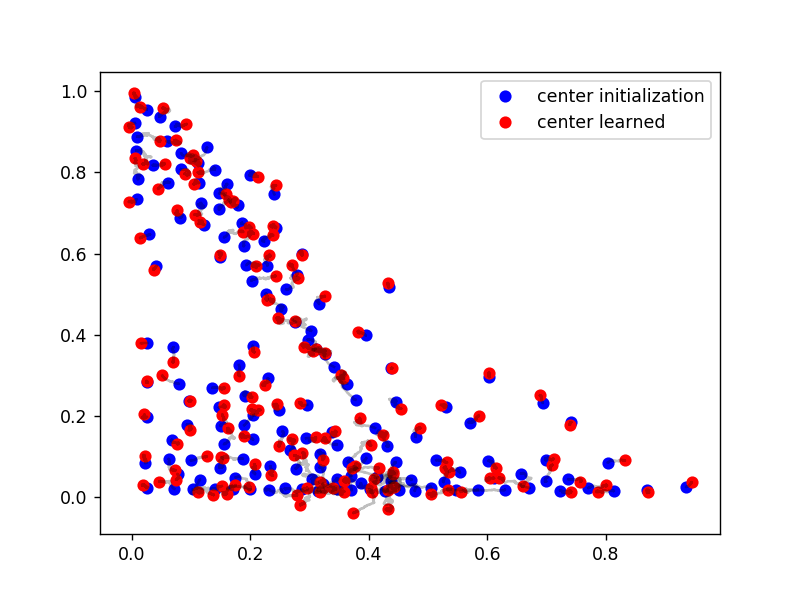

<IPython.core.display.Javascript object>


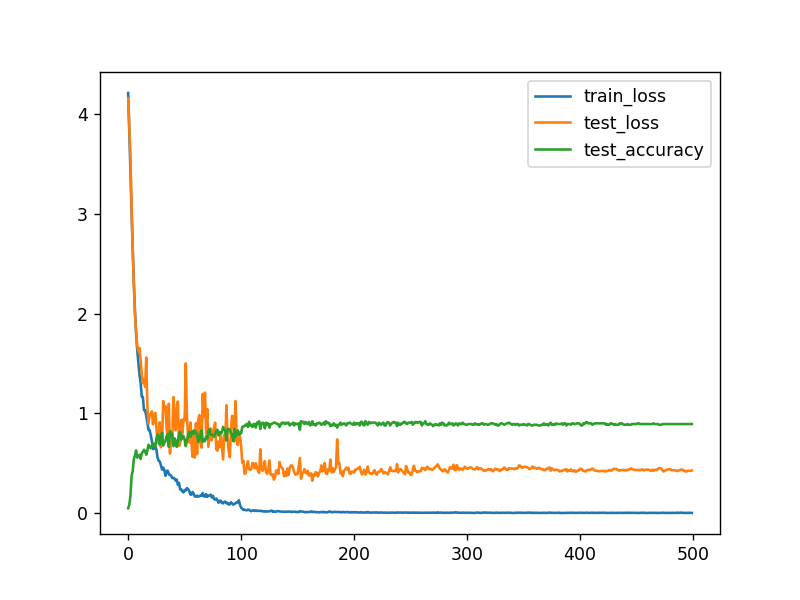

In [32]:
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()

In [33]:
stats['test_accuracy'][-20:]

[0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429,
 0.8928571428571429]

In [34]:
model.slayers['dim_0_dir_0'].exponent

Parameter containing:
 1.0078
 0.9992
 0.9937
 1.0087
 0.9974
 1.0025
 1.0023
 0.9967
 1.0085
 1.0040
 1.0048
 1.0059
 1.0031
 1.0063
 0.9976
 0.9960
 1.0029
 1.0076
 1.0028
 1.0105
 0.9959
 1.0028
 0.9997
 1.0076
 1.0073
 1.0044
 1.0020
 1.0022
 1.0059
 1.0000
 0.9994
 0.9998
 0.9982
 1.0012
 1.0051
 1.0025
 0.9987
 1.0042
 0.9952
 0.9958
 1.0066
 1.0062
 0.9993
 1.0079
 1.0059
 1.0071
 0.9995
 1.0086
 1.0037
 0.9982
 1.0048
 1.0069
 1.0019
 0.9965
 0.9992
 0.9998
 1.0019
 0.9968
 1.0012
 0.9998
 1.0060
 1.0048
 0.9962
 0.9974
 1.0003
 1.0048
 1.0056
 1.0064
 1.0001
 1.0077
 1.0030
 1.0009
 0.9956
 1.0020
 1.0015
 1.0002
 1.0080
 1.0141
 1.0023
 0.9953
 1.0025
 1.0065
 1.0003
 1.0025
 1.0025
 1.0000
 1.0092
 0.9998
 0.9994
 1.0010
 0.9991
 0.9954
 1.0046
 1.0059
 0.9974
 1.0003
 0.9988
 1.0103
 1.0012
 1.0036
 1.0033
 1.0037
 1.0075
 1.0009
 1.0009
 1.0024
 0.9926
 1.0054
 1.0047
 1.0166
 0.9930
 0.9995
 0.9983
 1.0000
 1.0042
 1.0028
 0.9941
 0.9974
 0.9910
 1.0002
 1.0059
 0.9983
 1